In [1]:
import os
import time 
import re
import codecs
import datetime 
import networkx as nx

root = '/home/tianyi/Python_projects/anomaly_data/data/enron/maildir'

In [2]:
def parse_line(line):
    if len(line)<=1:
        return []
    if '<' in line:
        names = [re.sub(r" ?\([^)]+\)", "", n).strip(', \'"\n\r\t') for n in (re.findall("(.*?)\<.*?\>", line)) if len(n.strip(', \'"\n\r'))>1]
    else:
        names = [re.sub(r" ?\([^)]+\)", "", n).strip(', \'"\n\r\t') for n in line.split(',')]
    names = [n.split(', ')[1]+' '+n.split(', ')[0] if len(n.split(', '))==2 else n for n in names]
    return names

def get_key(my_dict, val):
    for key, value in my_dict.items():
        if val == value:
            return key
 
    return "key doesn't exist"


In [3]:
def plot_S(node_map, S, G1, G2, fig_size=(20,10), node_size=30, with_labels=False, linewidths=0.5):
    if len(node_map)!=0:
        original_S = get_key(node_map, S)
    else:
        original_S = S
    g = G1.subgraph(original_S)
    h = G2.subgraph(original_S)
    h_deg = [deg for node,deg in h.degree()]
    
    try:
        print('min deg \t average deg \t max deg \t diameter \t triangle \t shortest path')
        print(min(h_deg), np.average(h_deg), max(h_deg), nx.diameter(h), sum(nx.triangles(h).values())/3, nx.average_shortest_path_length(h))
    except nx.NetworkXError:
        print('subgraph of H not connected')
    return g, h

In [4]:
def recur(path):
    global all_mails, all_ccs, mess_ids
    for file in os.listdir(path):
        if os.path.isdir(path + '/' + file):
            recur(path + '/' + file)
        else:
            try:
                f = codecs.open(path + '/' + file, 'r', errors='ignore')
                cur_file_from = []
                cur_file_to = []
                cur_file_cc = []
                cur_file_date = ''
                flag = 0
                for line in f:
                    if line.startswith('Message-ID'):
                        if line.split(':')[1].strip() in mess_ids:
                            break
                        mess_ids.add(line.split(':')[1].strip())
                        flag += 1
                    if line.startswith('X-From:'):
                        cur_file_from = parse_line(line[8:])
                        if len(cur_file_from) == 0:
                            break
                        flag += 1
                    if line.startswith('X-To:'):
                        cur_file_to = parse_line(line[6:])
                        flag += 1
                    if line.startswith('X-cc:'):
                        cur_file_cc = parse_line(line[6:])
                        flag += 1
                    if line.startswith('Date:'):
                        cur_file_date = ' '.join(line[6:].split(' ')[1:4])
                        flag += 1
                    if flag >= 5:
                        break

                if len(cur_file_from)==0:
                    continue
                if len(cur_file_to)!=0:
                    all_mails.append((cur_file_from,cur_file_to, cur_file_date))
                if len(cur_file_cc)!=0:
                    all_ccs.append((cur_file_from,cur_file_cc, cur_file_date))
            except UnicodeDecodeError:
                print(path + '/' + file)
                print(line)

mess_ids = set()
all_mails = []
all_ccs = []
recur(root)
                    

In [5]:
len(all_mails), len(all_ccs)

(508665, 515429)

In [6]:
mail_g = nx.Graph()
month_mapping = {'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06','Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}


for mail in all_mails:
    cur_date = mail[2]
    for word, num in month_mapping.items():
        cur_date = cur_date.replace(word, num)
#     print(cur_date)
    try:
        cur_date = time.mktime(datetime.datetime.strptime(cur_date, "%d %m %Y").timetuple())
    except ValueError:
        print(cur_date)
        continue
    for sender in mail[0]:
        for receiver in mail[1]:
            mail_g.add_edge(sender, receiver)

In [7]:
cc_g = nx.Graph()
month_mapping = {'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06','Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}


for mail in all_ccs:
    cur_date = mail[2]
    for word, num in month_mapping.items():
        cur_date = cur_date.replace(word, num)
#     print(cur_date)
    try:
        cur_date = time.mktime(datetime.datetime.strptime(cur_date, "%d %m %Y").timetuple())
    except ValueError:
        print(cur_date)
        continue
    for sender in mail[0]:
        for receiver in mail[1]:
            cc_g.add_edge(sender, receiver, time=cur_date)

In [8]:
from utils import *

In [9]:
to_remove = []
for n in mail_g.nodes:
    if '@' in n:
        to_remove.append(n)
mail_g.remove_nodes_from(to_remove)

to_remove = []
for n in cc_g.nodes:
    if '@' in n:
        to_remove.append(n)
cc_g.remove_nodes_from(to_remove)

len(mail_g.nodes), len(mail_g.edges), len(cc_g.nodes), len(cc_g.edges)

(54822, 232425, 23891, 77551)

In [10]:
node_map = {}
index = 0
for n in mail_g.nodes:
    if n not in node_map:
        node_map[n] = index
        index += 1
for n in cc_g.nodes:
    if n not in node_map:
        node_map[n] = index
        index += 1
mail_g = nx.relabel_nodes(mail_g, node_map)
cc_g = nx.relabel_nodes(cc_g, node_map)

mail_g.remove_edges_from(nx.selfloop_edges(mail_g))
cc_g.remove_edges_from(nx.selfloop_edges(cc_g))
common_nodes = set(mail_g.nodes) & set(cc_g.nodes)


('  ', 'iteration =', 1, 'level =', 1, 'nodes =', 20008, 20008)
('  ', 'Computing 2-connected components...')
('    ', 'iteration =', 2, 'level =', 2, 'nodes =', 19456, 19456)
('    ', 'Computing 2-connected components...')
done
('    ', 'iteration =', 3, 'level =', 2, 'nodes =', 10, 10)
('    ', 'Computing 2-connected components...')
done
     connected component found 10 3 3 9 5
('      ', 'iteration =', 4, 'level =', 3, 'nodes =', 9, 9)
('      ', 'Computing 2-connected components...')
done
       connected component found 9 4 4 7 5
('        ', 'iteration =', 5, 'level =', 4, 'nodes =', 7, 7)
('        ', 'Computing 2-connected components...')
done
         connected component found 7 5 5 0 5
('          ', 'iteration =', 6, 'level =', 5, 'nodes =', 0, 0)
('          ', 'Computing 2-connected components...')
('      ', 'iteration =', 7, 'level =', 3, 'nodes =', 4, 4)
('      ', 'Computing 2-connected components...')
('        ', 'iteration =', 8, 'level =', 4, 'nodes =', 3, 3)
('  

done
                                                       connected component found 877 18 18 747 27
('                                                        ', 'iteration =', 45, 'level =', 28, 'nodes =', 747, 747)
('                                                        ', 'Computing 2-connected components...')
done
('                                                        ', 'iteration =', 46, 'level =', 28, 'nodes =', 746, 746)
('                                                        ', 'Computing 2-connected components...')
done
                                                         connected component found 746 19 19 587 27
('                                                          ', 'iteration =', 47, 'level =', 29, 'nodes =', 587, 587)
('                                                          ', 'Computing 2-connected components...')
done
                                                           connected component found 587 20 20 525 27
('                          

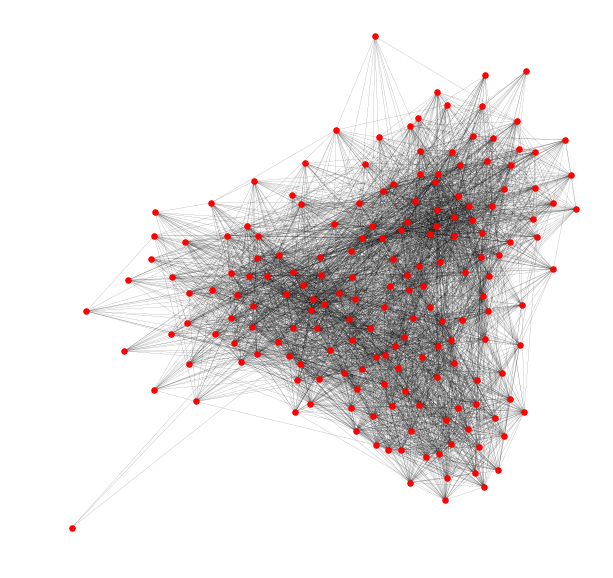

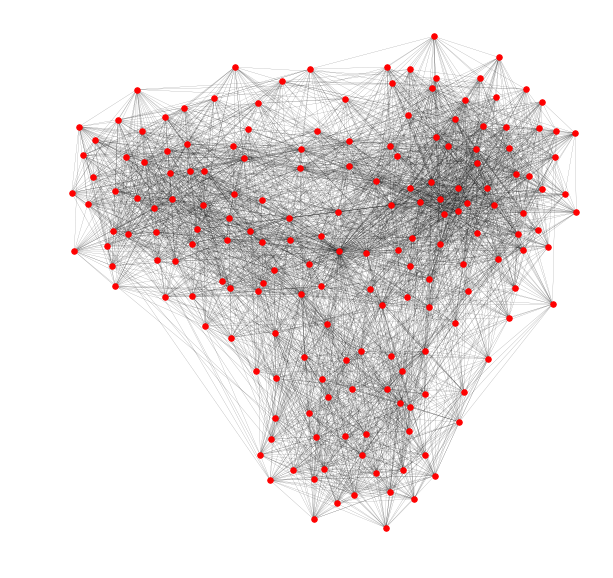

('  ', 'iteration =', 1, 'level =', 1, 'nodes =', 20008, 20008)
('  ', 'Computing 4-connected components...')
('    ', 'iteration =', 2, 'level =', 2, 'nodes =', 19456, 19456)
('    ', 'Computing 4-connected components...')
done
('    ', 'iteration =', 3, 'level =', 2, 'nodes =', 8900, 8900)
('    ', 'Computing 4-connected components...')
('      ', 'iteration =', 4, 'level =', 3, 'nodes =', 8767, 8767)
('      ', 'Computing 4-connected components...')
done
('      ', 'iteration =', 5, 'level =', 3, 'nodes =', 8754, 8754)
('      ', 'Computing 4-connected components...')
done
       connected component found 8754 1 1 6789 27
('        ', 'iteration =', 6, 'level =', 4, 'nodes =', 6789, 6789)
('        ', 'Computing 4-connected components...')
done
('        ', 'iteration =', 7, 'level =', 4, 'nodes =', 6618, 6618)
('        ', 'Computing 4-connected components...')
('          ', 'iteration =', 8, 'level =', 5, 'nodes =', 6604, 6604)
('          ', 'Computing 4-connected components...'

done
                                                         connected component found 1043 17 17 875 27
('                                                          ', 'iteration =', 44, 'level =', 29, 'nodes =', 875, 875)
('                                                          ', 'Computing 4-connected components...')
done
                                                           connected component found 875 18 18 745 27
('                                                            ', 'iteration =', 45, 'level =', 30, 'nodes =', 745, 745)
('                                                            ', 'Computing 4-connected components...')
done
                                                             connected component found 745 19 19 584 27
('                                                              ', 'iteration =', 46, 'level =', 31, 'nodes =', 584, 584)
('                                                              ', 'Computing 4-connected components...')
done
 

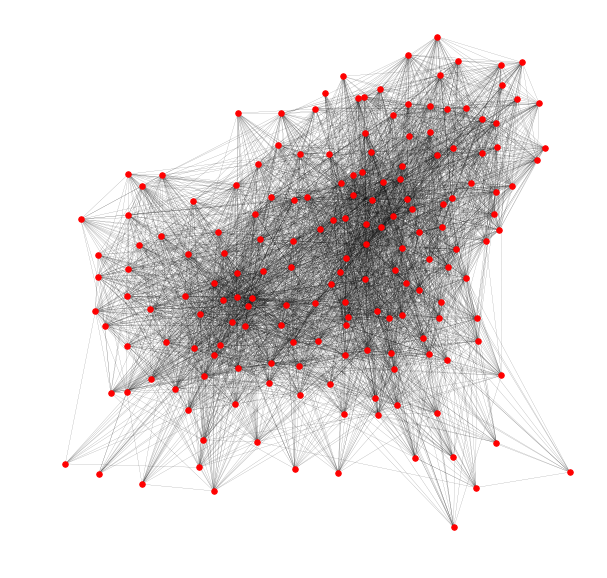

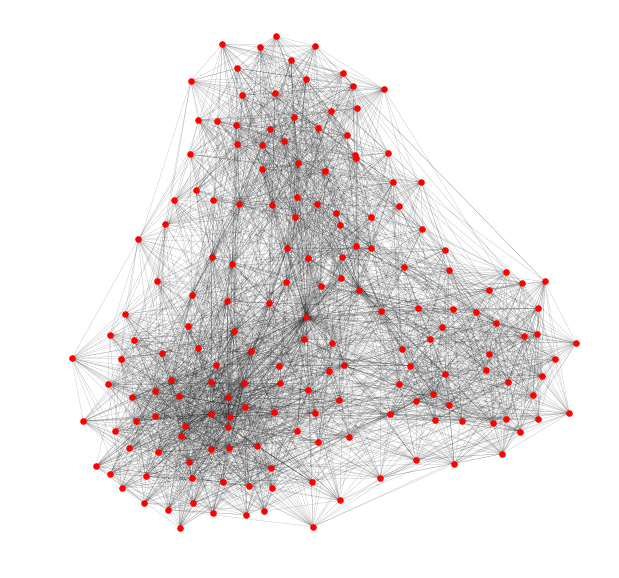

('  ', 'iteration =', 1, 'level =', 1, 'nodes =', 20008, 20008)
('  ', 'Computing 6-connected components...')
('    ', 'iteration =', 2, 'level =', 2, 'nodes =', 19456, 19456)
('    ', 'Computing 6-connected components...')
done
('    ', 'iteration =', 3, 'level =', 2, 'nodes =', 7338, 7338)
('    ', 'Computing 6-connected components...')
('      ', 'iteration =', 4, 'level =', 3, 'nodes =', 7299, 7299)
('      ', 'Computing 6-connected components...')
done
('      ', 'iteration =', 5, 'level =', 3, 'nodes =', 7292, 7292)
('      ', 'Computing 6-connected components...')
done
       connected component found 7292 1 1 6105 27
('        ', 'iteration =', 6, 'level =', 4, 'nodes =', 6105, 6105)
('        ', 'Computing 6-connected components...')
done
('        ', 'iteration =', 7, 'level =', 4, 'nodes =', 5940, 5940)
('        ', 'Computing 6-connected components...')
('          ', 'iteration =', 8, 'level =', 5, 'nodes =', 5919, 5919)
('          ', 'Computing 6-connected components...'

done
                                                           connected component found 1178 16 16 1035 27
('                                                            ', 'iteration =', 45, 'level =', 30, 'nodes =', 1035, 1035)
('                                                            ', 'Computing 6-connected components...')
done
                                                             connected component found 1035 17 17 869 27
('                                                              ', 'iteration =', 46, 'level =', 31, 'nodes =', 869, 869)
('                                                              ', 'Computing 6-connected components...')
done
                                                               connected component found 869 18 18 734 27
('                                                                ', 'iteration =', 47, 'level =', 32, 'nodes =', 734, 734)
('                                                                ', 'Computing 6-connected 

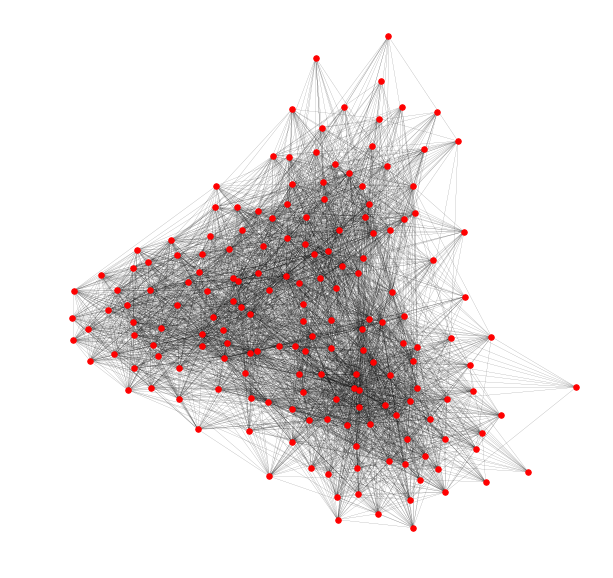

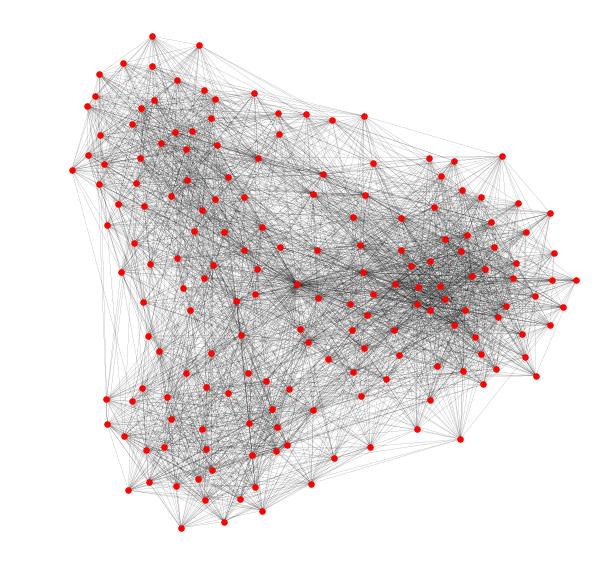

('  ', 'iteration =', 1, 'level =', 1, 'nodes =', 20008, 20008)
('  ', 'Computing 10-connected components...')
('    ', 'iteration =', 2, 'level =', 2, 'nodes =', 19456, 19456)
('    ', 'Computing 10-connected components...')
done
('    ', 'iteration =', 3, 'level =', 2, 'nodes =', 5550, 5550)
('    ', 'Computing 10-connected components...')
('      ', 'iteration =', 4, 'level =', 3, 'nodes =', 5519, 5519)
('      ', 'Computing 10-connected components...')
done
('      ', 'iteration =', 5, 'level =', 3, 'nodes =', 5515, 5515)
('      ', 'Computing 10-connected components...')
done
       connected component found 5515 1 1 4958 27
('        ', 'iteration =', 6, 'level =', 4, 'nodes =', 4958, 4958)
('        ', 'Computing 10-connected components...')
done
('        ', 'iteration =', 7, 'level =', 4, 'nodes =', 4801, 4801)
('        ', 'Computing 10-connected components...')
('          ', 'iteration =', 8, 'level =', 5, 'nodes =', 4798, 4798)
('          ', 'Computing 10-connected compon

done
                                                       connected component found 1948 11 11 1780 27
('                                                        ', 'iteration =', 48, 'level =', 28, 'nodes =', 1780, 1780)
('                                                        ', 'Computing 10-connected components...')
done
('                                                        ', 'iteration =', 49, 'level =', 28, 'nodes =', 1775, 1775)
('                                                        ', 'Computing 10-connected components...')
('                                                          ', 'iteration =', 50, 'level =', 29, 'nodes =', 1772, 1772)
('                                                          ', 'Computing 10-connected components...')
done
                                                           connected component found 1772 12 12 1614 27
('                                                            ', 'iteration =', 51, 'level =', 30, 'nodes =', 1614, 1614

done
                                                                                             connected component found 379 23 23 339 27
('                                                                                              ', 'iteration =', 76, 'level =', 47, 'nodes =', 339, 339)
('                                                                                              ', 'Computing 10-connected components...')
done
('                                                                                              ', 'iteration =', 77, 'level =', 47, 'nodes =', 338, 338)
('                                                                                              ', 'Computing 10-connected components...')
('                                                                                                ', 'iteration =', 78, 'level =', 48, 'nodes =', 331, 331)
('                                                                                                ', 'Computing 

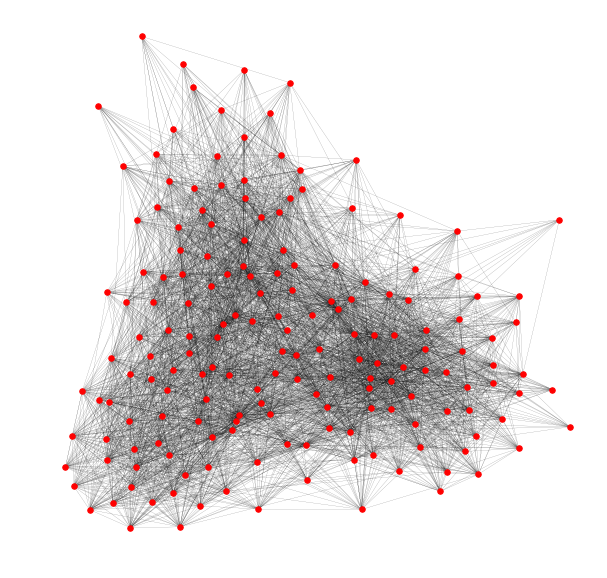

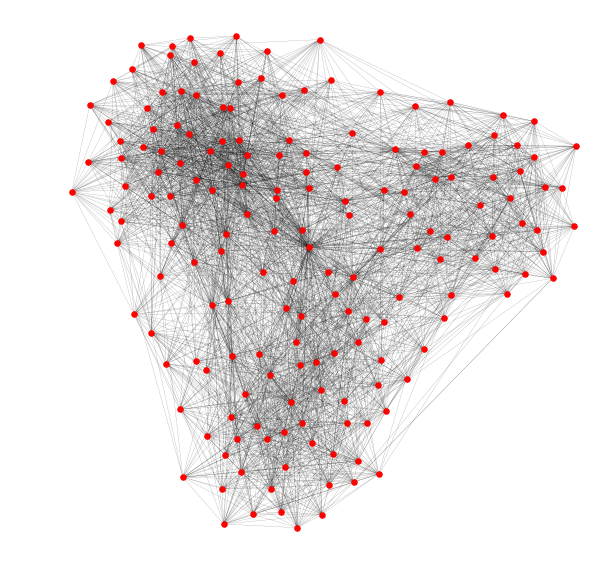

In [12]:
enron_S = []
for k in [2, 4, 6, 10]:
    S, mindeg = k_conn_min_deg(mail_g.subgraph(common_nodes), cc_g.subgraph(common_nodes), k, verbose=True)
    print 'size of dense-connected subgraph', len(S)
    print '# of edges in the k-connected subgraph', len(mail_g.subgraph(S).edges)
    print '# of edges in the dense subgraph', len(cc_g.subgraph(S).edges) 
    
    g, h = plot_S(dict(), S, mail_g, cc_g)
    
    fig, axes = plt.subplots(figsize=(10,10), nrows=1, ncols=1)
    nx.draw_networkx(g, ax=axes, with_labels=False, node_size=30, width=0.1)
    axes.set_axis_off()
    plt.savefig('enron_figs/mail_cc_k=' + str(k) + '_connect.png')
    
    fig, axes = plt.subplots(figsize=(10,10), nrows=1, ncols=1)
    nx.draw_networkx(h, ax=axes, with_labels=False, node_size=30, width=0.1)
    axes.set_axis_off()
    
    plt.savefig('enron_figs/mail_cc_k=' + str(k) + '_dense.png')
#     fig_idx += 1
    plt.show()
    
    enron_S.append(S)
# S, mindeg = k_conn_min_deg(mail_g, cc_g, 2, verbose=True)

In [ ]:
# connected component found 11907 1 1 7884 27

In [ ]:
#  Kenneth L. Lay, Enron chairman and CEO
#  Jeffrey McMahon, Enron chief financial officer.
#  Mark Frevert, Enron vice chairman

In [14]:
for s in enron_S[0]:
    print(get_key(node_map, s))


Nicki Daw
Deb Korkmas
Liz M Taylor
Sandra McCubbin
Bernadette Hawkins
Ginger Dernehl
Karen Denne
Wes Colwell
Christopher F Calger
Alan Comnes
Gerald Nemec
Vince J Kaminski
Marsha Schiller
Rick Buy
Michael Tribolet
David Oxley
Peter Styles
Billy Dorsey
James D. Steffes
Sherri Sera
Pat Radford
Mark E. Haedicke
Tina Spiller
Linda Robertson
Michael R Brown
Julie Clyatt
Marie Heard
Rob Bradley
Susan Mara
Mark Taylor
Joe Connor
Harry Kingerski
Joe Hartsoe
Stuart Zisman
Billy Lemmons Jr.
Brian Redmond
Christi L. Nicolay
Cathy Phillips
Tim Belden
Bobbie Power
Carol Moffett
Don Black
Julia Murray
Greg Piper
Shari Stack
Kay Chapman
Rebecca W. Cantrell
Edward Sacks
Paula Rieker
Shelley Corman
Hedy Govenar
Jennifer Burns
Barry Tycholiz
Sara Shackleton
Mark Frevert
Taffy Milligan
Rebecca W Cantrell
Dan Leff
John Shelk
Tana Jones
Twanda Sweet
Billy
Steve Montovano
Janel Guerrero
Amr Ibrahim
Mary Hain
Daniel Allegretti
Tori L. Wells
Marcia A Linton
Christie Patrick
Connie Blackwood
Roger Yang
Cindy 

In [17]:
for s in set(enron_S[0])-set(enron_S[3]):
    print(get_key(node_map, s))

Tori L. Wells
Lemmons Jr.
Peggy McCurley
Kenneth Lay
Tina Spiller
Marty Sunde


('  ', 'iteration =', 1, 'level =', 1, 'nodes =', 20008, 20008)
('  ', 'Computing 2-connected components...')
('    ', 'iteration =', 2, 'level =', 2, 'nodes =', 17277, 17277)
('    ', 'Computing 2-connected components...')
done
('    ', 'iteration =', 3, 'level =', 2, 'nodes =', 4, 4)
('    ', 'Computing 2-connected components...')
('      ', 'iteration =', 4, 'level =', 3, 'nodes =', 0, 0)
('      ', 'Computing 2-connected components...')
('      ', 'iteration =', 5, 'level =', 3, 'nodes =', 8660, 8660)
('      ', 'Computing 2-connected components...')
('        ', 'iteration =', 6, 'level =', 4, 'nodes =', 8597, 8597)
('        ', 'Computing 2-connected components...')
done
('        ', 'iteration =', 7, 'level =', 4, 'nodes =', 8542, 8542)
('        ', 'Computing 2-connected components...')
done
         connected component found 8542 1 1 7854 47
('          ', 'iteration =', 8, 'level =', 5, 'nodes =', 7854, 7854)
('          ', 'Computing 2-connected components...')
done
('      

done
                                                     connected component found 3761 15 15 3629 47
('                                                      ', 'iteration =', 45, 'level =', 27, 'nodes =', 3629, 3629)
('                                                      ', 'Computing 2-connected components...')
done
('                                                      ', 'iteration =', 46, 'level =', 27, 'nodes =', 3627, 3627)
('                                                      ', 'Computing 2-connected components...')
done
                                                       connected component found 3627 16 16 3469 47
('                                                        ', 'iteration =', 47, 'level =', 28, 'nodes =', 3469, 3469)
('                                                        ', 'Computing 2-connected components...')
done
('                                                        ', 'iteration =', 48, 'level =', 28, 'nodes =', 3467, 3467)
('                

('                                                                                        ', 'iteration =', 73, 'level =', 44, 'nodes =', 2358, 2358)
('                                                                                        ', 'Computing 2-connected components...')
done
                                                                                         connected component found 2358 27 27 2265 47
('                                                                                          ', 'iteration =', 74, 'level =', 45, 'nodes =', 2265, 2265)
('                                                                                          ', 'Computing 2-connected components...')
done
('                                                                                          ', 'iteration =', 75, 'level =', 45, 'nodes =', 2263, 2263)
('                                                                                          ', 'Computing 2-connected components...')
do

done
('                                                                                                                    ', 'iteration =', 95, 'level =', 58, 'nodes =', 1435, 1435)
('                                                                                                                    ', 'Computing 2-connected components...')
('                                                                                                                      ', 'iteration =', 96, 'level =', 59, 'nodes =', 1434, 1434)
('                                                                                                                      ', 'Computing 2-connected components...')
done
                                                                                                                       connected component found 1434 38 38 1356 47
('                                                                                                                        ', 'iteration =', 97, 'l

done
('                                                                                                                                                ', 'iteration =', 114, 'level =', 72, 'nodes =', 266, 266)
('                                                                                                                                                ', 'Computing 2-connected components...')
('                                                                                                                                                  ', 'iteration =', 115, 'level =', 73, 'nodes =', 265, 265)
('                                                                                                                                                  ', 'Computing 2-connected components...')
done
                                                                                                                                                   connected component found 265 47 47 0 47
('          

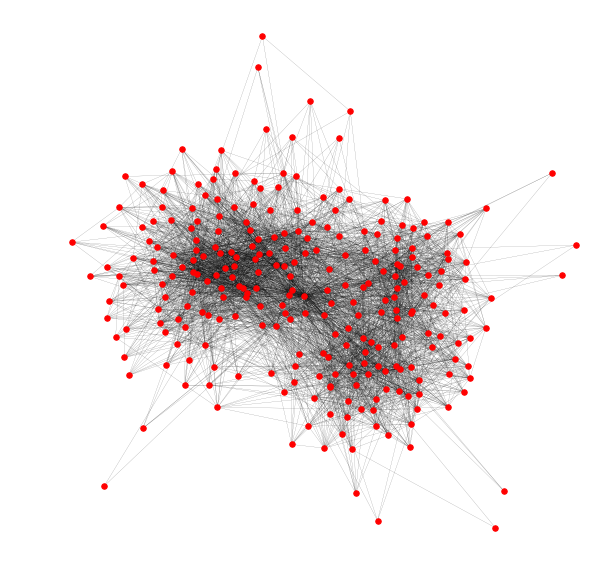

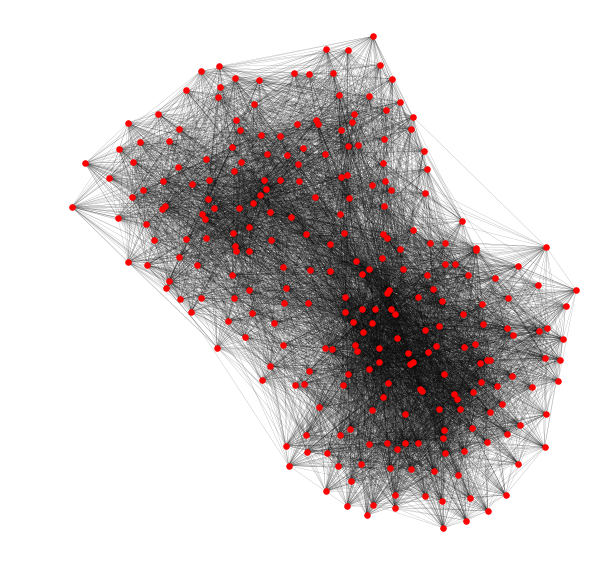

('  ', 'iteration =', 1, 'level =', 1, 'nodes =', 20008, 20008)
('  ', 'Computing 4-connected components...')
('    ', 'iteration =', 2, 'level =', 2, 'nodes =', 17277, 17277)
('    ', 'Computing 4-connected components...')
done
('    ', 'iteration =', 3, 'level =', 2, 'nodes =', 5259, 5259)
('    ', 'Computing 4-connected components...')
('      ', 'iteration =', 4, 'level =', 3, 'nodes =', 5238, 5238)
('      ', 'Computing 4-connected components...')
done
('      ', 'iteration =', 5, 'level =', 3, 'nodes =', 5235, 5235)
('      ', 'Computing 4-connected components...')
done
       connected component found 5235 1 1 5120 47
('        ', 'iteration =', 6, 'level =', 4, 'nodes =', 5120, 5120)
('        ', 'Computing 4-connected components...')
done
('        ', 'iteration =', 7, 'level =', 4, 'nodes =', 5107, 5107)
('        ', 'Computing 4-connected components...')
done
         connected component found 5107 2 2 4972 47
('          ', 'iteration =', 8, 'level =', 5, 'nodes =', 4972, 4

done
('                                                        ', 'iteration =', 46, 'level =', 28, 'nodes =', 3187, 3187)
('                                                        ', 'Computing 4-connected components...')
('                                                          ', 'iteration =', 47, 'level =', 29, 'nodes =', 3185, 3185)
('                                                          ', 'Computing 4-connected components...')
done
                                                           connected component found 3185 15 15 3095 46
('                                                            ', 'iteration =', 48, 'level =', 30, 'nodes =', 3095, 3095)
('                                                            ', 'Computing 4-connected components...')
done
('                                                            ', 'iteration =', 49, 'level =', 30, 'nodes =', 3091, 3091)
('                                                            ', 'Computing 4-connected compo

done
('                                                                                            ', 'iteration =', 74, 'level =', 46, 'nodes =', 2347, 2347)
('                                                                                            ', 'Computing 4-connected components...')
('                                                                                              ', 'iteration =', 75, 'level =', 47, 'nodes =', 2346, 2346)
('                                                                                              ', 'Computing 4-connected components...')
done
                                                                                               connected component found 2346 24 24 2263 46
('                                                                                                ', 'iteration =', 76, 'level =', 48, 'nodes =', 2263, 2263)
('                                                                                                ', 'Comput

done
('                                                                                                                          ', 'iteration =', 97, 'level =', 61, 'nodes =', 1723, 1723)
('                                                                                                                          ', 'Computing 4-connected components...')
('                                                                                                                            ', 'iteration =', 98, 'level =', 62, 'nodes =', 1702, 1702)
('                                                                                                                            ', 'Computing 4-connected components...')
done
('                                                                                                                            ', 'iteration =', 99, 'level =', 62, 'nodes =', 1699, 1699)
('                                                                                                  

done
                                                                                                                                                 connected component found 1078 39 39 1039 46
('                                                                                                                                                  ', 'iteration =', 116, 'level =', 73, 'nodes =', 1039, 1039)
('                                                                                                                                                  ', 'Computing 4-connected components...')
done
                                                                                                                                                   connected component found 1039 40 40 976 46
('                                                                                                                                                    ', 'iteration =', 117, 'level =', 74, 'nodes =', 976, 976)
(

('              ', 'iteration =', 133, 'level =', 7, 'nodes =', 5, 5)
('              ', 'Computing 4-connected components...')
('                ', 'iteration =', 134, 'level =', 8, 'nodes =', 0, 0)
('                ', 'Computing 4-connected components...')
size(S) = 348
size of dense-connected subgraph 348
# of edges in the k-connected subgraph 6373
# of edges in the dense subgraph 13679
min deg 	 average deg 	 max deg 	 diameter 	 triangle 	 shortest path
(46, 78.61494252873563, 202, 3, 186665, 1.789592235582497)


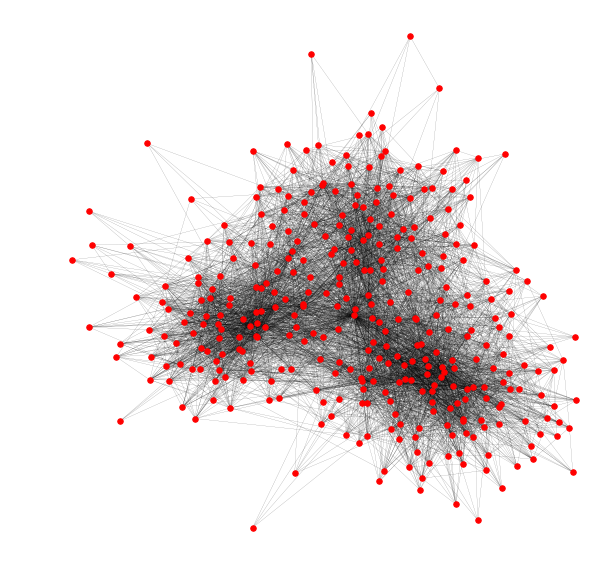

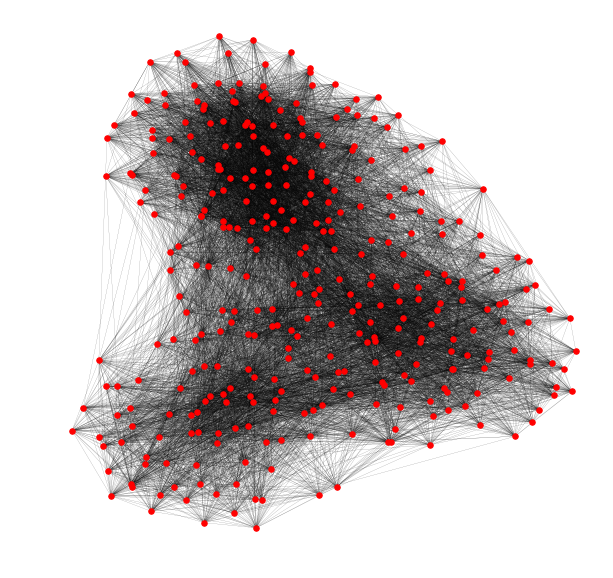

('  ', 'iteration =', 1, 'level =', 1, 'nodes =', 20008, 20008)
('  ', 'Computing 6-connected components...')
('    ', 'iteration =', 2, 'level =', 2, 'nodes =', 17277, 17277)
('    ', 'Computing 6-connected components...')
done
('    ', 'iteration =', 3, 'level =', 2, 'nodes =', 3865, 3865)
('    ', 'Computing 6-connected components...')
('      ', 'iteration =', 4, 'level =', 3, 'nodes =', 3855, 3855)
('      ', 'Computing 6-connected components...')
done
('      ', 'iteration =', 5, 'level =', 3, 'nodes =', 3845, 3845)
('      ', 'Computing 6-connected components...')
done
       connected component found 3845 1 1 3805 46
('        ', 'iteration =', 6, 'level =', 4, 'nodes =', 3805, 3805)
('        ', 'Computing 6-connected components...')
done
('        ', 'iteration =', 7, 'level =', 4, 'nodes =', 3795, 3795)
('        ', 'Computing 6-connected components...')
done
         connected component found 3795 2 2 3739 46
('          ', 'iteration =', 8, 'level =', 5, 'nodes =', 3739, 3

done
                                                   connected component found 2672 16 16 2609 46
('                                                    ', 'iteration =', 46, 'level =', 26, 'nodes =', 2609, 2609)
('                                                    ', 'Computing 6-connected components...')
done
('                                                    ', 'iteration =', 47, 'level =', 26, 'nodes =', 2605, 2605)
('                                                    ', 'Computing 6-connected components...')
('                                                      ', 'iteration =', 48, 'level =', 27, 'nodes =', 2597, 2597)
('                                                      ', 'Computing 6-connected components...')
done
('                                                      ', 'iteration =', 49, 'level =', 27, 'nodes =', 2596, 2596)
('                                                      ', 'Computing 6-connected components...')
('                                       

done
('                                                                                        ', 'iteration =', 76, 'level =', 44, 'nodes =', 1908, 1908)
('                                                                                        ', 'Computing 6-connected components...')
('                                                                                          ', 'iteration =', 77, 'level =', 45, 'nodes =', 1907, 1907)
('                                                                                          ', 'Computing 6-connected components...')
done
                                                                                           connected component found 1907 26 26 1869 46
('                                                                                            ', 'iteration =', 78, 'level =', 46, 'nodes =', 1869, 1869)
('                                                                                            ', 'Computing 6-connected components..

done
                                                                                                                       connected component found 1413 34 34 1358 46
('                                                                                                                        ', 'iteration =', 99, 'level =', 60, 'nodes =', 1358, 1358)
('                                                                                                                        ', 'Computing 6-connected components...')
done
('                                                                                                                        ', 'iteration =', 100, 'level =', 60, 'nodes =', 1356, 1356)
('                                                                                                                        ', 'Computing 6-connected components...')
('                                                                                                                          ', 'itera

('                                                                                                                                                ', 'iteration =', 119, 'level =', 72, 'nodes =', 878, 878)
('                                                                                                                                                ', 'Computing 6-connected components...')
done
                                                                                                                                                 connected component found 878 40 40 823 46
('                                                                                                                                                  ', 'iteration =', 120, 'level =', 73, 'nodes =', 823, 823)
('                                                                                                                                                  ', 'Computing 6-connected components...')
done
('          

size(S) = 474
size of dense-connected subgraph 474
# of edges in the k-connected subgraph 8794
# of edges in the dense subgraph 18956
min deg 	 average deg 	 max deg 	 diameter 	 triangle 	 shortest path
(45, 79.9831223628692, 271, 3, 237210, 1.8574945807798324)


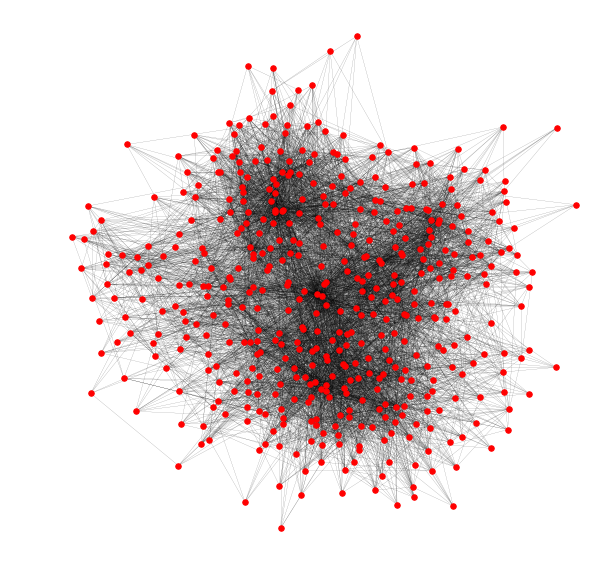

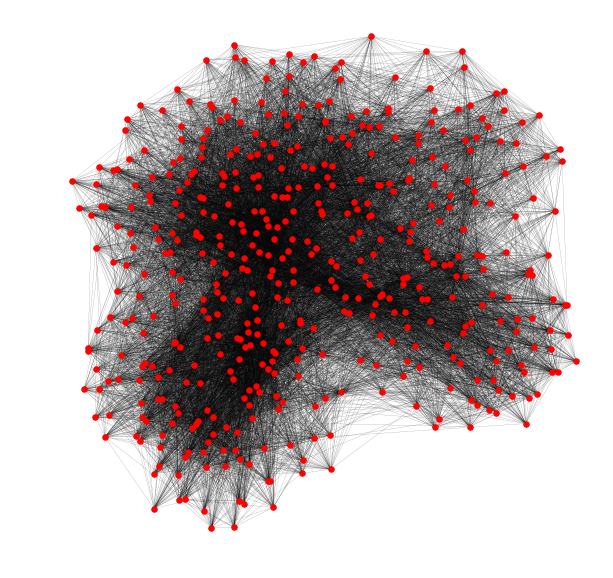

('  ', 'iteration =', 1, 'level =', 1, 'nodes =', 20008, 20008)
('  ', 'Computing 10-connected components...')
('    ', 'iteration =', 2, 'level =', 2, 'nodes =', 17277, 17277)
('    ', 'Computing 10-connected components...')
done
('    ', 'iteration =', 3, 'level =', 2, 'nodes =', 2390, 2390)
('    ', 'Computing 10-connected components...')
done
     connected component found 2390 1 1 2374 46
('      ', 'iteration =', 4, 'level =', 3, 'nodes =', 2374, 2374)
('      ', 'Computing 10-connected components...')
done
('      ', 'iteration =', 5, 'level =', 3, 'nodes =', 2347, 2347)
('      ', 'Computing 10-connected components...')
done
       connected component found 2347 2 2 2336 46
('        ', 'iteration =', 6, 'level =', 4, 'nodes =', 2336, 2336)
('        ', 'Computing 10-connected components...')
done
('        ', 'iteration =', 7, 'level =', 4, 'nodes =', 2326, 2326)
('        ', 'Computing 10-connected components...')
done
         connected component found 2326 3 3 2314 46
('   

('                                                  ', 'iteration =', 45, 'level =', 25, 'nodes =', 1814, 1814)
('                                                  ', 'Computing 10-connected components...')
done
                                                   connected component found 1814 19 19 1790 46
('                                                    ', 'iteration =', 46, 'level =', 26, 'nodes =', 1790, 1790)
('                                                    ', 'Computing 10-connected components...')
done
('                                                    ', 'iteration =', 47, 'level =', 26, 'nodes =', 1778, 1778)
('                                                    ', 'Computing 10-connected components...')
('                                                      ', 'iteration =', 48, 'level =', 27, 'nodes =', 1776, 1776)
('                                                      ', 'Computing 10-connected components...')
done
                                             

('                                                                                      ', 'iteration =', 75, 'level =', 43, 'nodes =', 1468, 1468)
('                                                                                      ', 'Computing 10-connected components...')
done
('                                                                                      ', 'iteration =', 76, 'level =', 43, 'nodes =', 1467, 1467)
('                                                                                      ', 'Computing 10-connected components...')
done
                                                                                       connected component found 1467 27 27 1426 45
('                                                                                        ', 'iteration =', 77, 'level =', 44, 'nodes =', 1426, 1426)
('                                                                                        ', 'Computing 10-connected components...')
done
('          

done
('                                                                                                                  ', 'iteration =', 99, 'level =', 57, 'nodes =', 1002, 1002)
('                                                                                                                  ', 'Computing 10-connected components...')
('                                                                                                                    ', 'iteration =', 100, 'level =', 58, 'nodes =', 925, 925)
('                                                                                                                    ', 'Computing 10-connected components...')
done
('                                                                                                                    ', 'iteration =', 101, 'level =', 58, 'nodes =', 922, 922)
('                                                                                                                    ', 'Computing 10-conne

done
('                                                                                                                                          ', 'iteration =', 119, 'level =', 69, 'nodes =', 628, 628)
('                                                                                                                                          ', 'Computing 10-connected components...')
('                                                                                                                                            ', 'iteration =', 120, 'level =', 70, 'nodes =', 625, 625)
('                                                                                                                                            ', 'Computing 10-connected components...')
done
                                                                                                                                             connected component found 625 41 41 581 45
('                                    

done
                                                                                                                                                                 connected component found 226 45 45 0 45
('                                                                                                                                                                  ', 'iteration =', 139, 'level =', 81, 'nodes =', 0, 0)
('                                                                                                                                                                  ', 'Computing 10-connected components...')
size(S) = 226
size of dense-connected subgraph 226
# of edges in the k-connected subgraph 4076
# of edges in the dense subgraph 8036
min deg 	 average deg 	 max deg 	 diameter 	 triangle 	 shortest path
(45, 71.11504424778761, 159, 3, 105988, 1.6865683382497543)


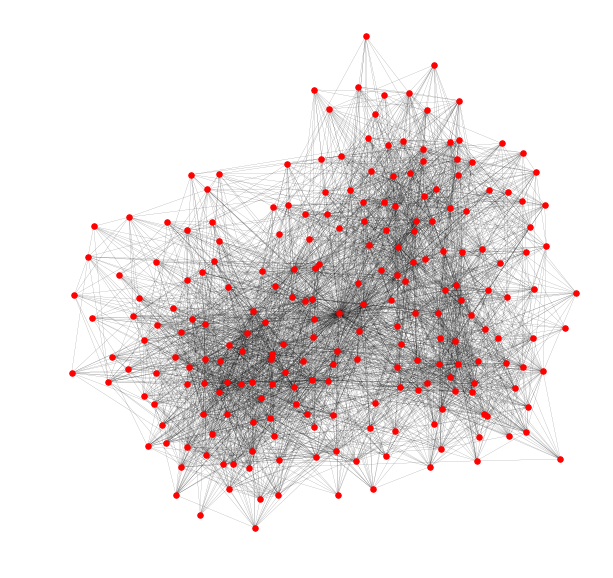

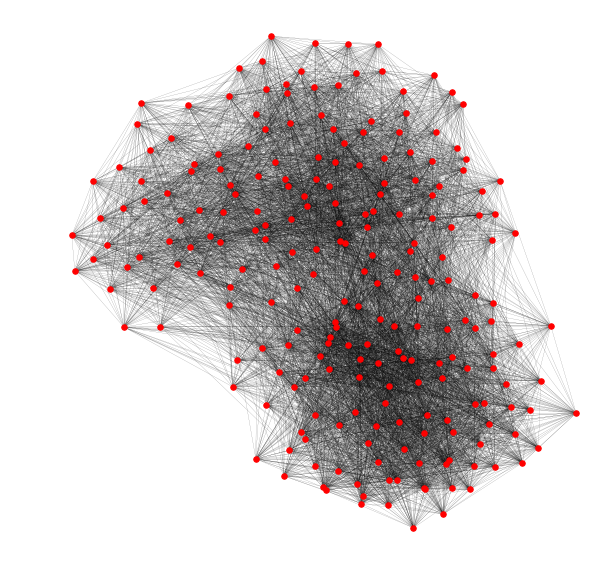

In [19]:
cc_S = []
for k in [2, 4, 6, 10]:
    S, mindeg = k_conn_min_deg(cc_g.subgraph(common_nodes), mail_g.subgraph(common_nodes), k, verbose=True)
    print 'size of dense-connected subgraph', len(S)
    print '# of edges in the k-connected subgraph', len(cc_g.subgraph(S).edges) 
    print '# of edges in the dense subgraph', len(mail_g.subgraph(S).edges)
    
    g, h = plot_S(dict(), S, cc_g, mail_g)
    
    fig, axes = plt.subplots(figsize=(10,10), nrows=1, ncols=1)
    nx.draw_networkx(g, ax=axes, with_labels=False, node_size=30, width=0.1)
    axes.set_axis_off()
#     plt.savefig('enron_figs/mail_cc_k=' + str(k) + '_connect.png')
    
    fig, axes = plt.subplots(figsize=(10,10), nrows=1, ncols=1)
    nx.draw_networkx(h, ax=axes, with_labels=False, node_size=30, width=0.1)
    axes.set_axis_off()
    
#     plt.savefig('enron_figs/mail_cc_k=' + str(k) + '_dense.png')
#     fig_idx += 1
    plt.show()
    
    cc_S.append(S)
# S, mindeg = k_conn_min_deg(mail_g, cc_g, 2, verbose=True)